In [4]:
import tensorflow as tf
#import tensorflow.contrib.learn.python.learn as learn
import tflearn 
import scipy as sp
from scipy.signal import find_peaks_cwt as peakFinder
import numpy as np 
import matplotlib.pyplot as plt
from random import shuffle, randint
import pandas as pd
import six
from sklearn.utils import shuffle as mutualShuf
from sklearn.preprocessing import normalize
from sklearn.metrics import roc_curve
import datetime
%matplotlib inline

# Import and process data

In [5]:
def importPickle(fileLocation): # File location is ./inData/6060DataFrame.pkl
    """
    Imports Daniel Wilson's datafile and respectively returns a matrix of class 
    (whether patient is healthy or unhealthy) data, and a matrix of coil data.
    """
    # Import dataframe
    path60  = fileLocation
    df60 = pd.read_pickle(path60)
    # Separate pandas dataframe into classification and data arrays
    classData = df60["Classification"].as_matrix()
    coilData = df60["Coil Data"].as_matrix()
    
    return classData, coilData

def splitData(coilData, classData):
    """
    Split data into healthy and ill types.
    """
    illData = []
    healthData = []
    
    for index, item in enumerate(classData):
        if item == 1:
            illData.append(coilData[index])
        if item == 0:
            healthData.append(coilData[index])
            
    return illData, healthData

classData, coilData = importPickle("./inData/6060DataFrame.pkl")
# Normalise the data
for index, item in enumerate(coilData):
    coilData[index] = normalize(item, axis=1)

illData, healthData = splitData(coilData, classData)
illUnseen = np.vstack(np.array(illData[:20]))#[:,::40]
healthUnseen = np.vstack(np.array(healthData[:20]))#[:,::40]
illData = np.vstack(np.array(illData[20:]))#[:,::40]
healthData = np.vstack(np.array(healthData[20:]))#[:,::40]
print(illData.shape, healthData.shape,"\n", illUnseen.shape, healthUnseen.shape)

(2640, 2000) (2760, 2000) 
 (300, 2000) (300, 2000)


137


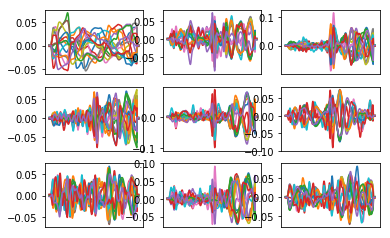

In [6]:
# Various plots...
r = randint(0,390)
print(r)
fig, ax = plt.subplots(3,3)
for i in np.arange(0,ax.shape[0],1):
    for j in np.arange(0,ax.shape[1],1):
        r = r+1
        for k in np.arange(0,15):
            ax[i,j].plot(coilData[r][k, 0:2000])
            ax[i,j].set_xticks([])

In [9]:
def processClassData(classData):
    """
    Process classData.
    
    Returns a one-hot array of shape [len(classData), 2].
    """
    # Convert label data to one-hot array
          
    classDataOH = np.zeros((len(classData),2))
    classDataOH[np.arange(len(classData)), classData] = 1
    
    return classDataOH

def visualiseData(ecgData, classData, gridSize, axis):
    """
    Plot labelled example data in a gridSize*gridSize grid.
    """
    fig, ax = plt.subplots(gridSize, gridSize)
    plt.suptitle("Labelled example data")
    r = randint(0,len(classData)-16)
    k = 0
    for i in np.arange(0,gridSize,1):
        for j in np.arange(0,gridSize,1):
            k = k + 1
            ax[i,j].plot(ecgData[r+k])
            if axis == False:
                ax[i,j].axis("off")
            ax[i,j].annotate(classData[r+k], xy=(0, 0), xycoords='axes points',\
                        size=10, ha='left', va='top')

def functionTown(illArr, healthArr, shuffle):
    """
    Return the processed ecgData and the classData (one-hot). Also return arrays of ill and healthy ppts.
    If shuffle is true, shuffle data.
    """
    
    print("ill samples", len(illArr))
    print("healthy samples", len(healthArr))
    
    classData = []
    for i in np.arange(0, len(illArr), 1):
        classData.append(1)
    for i in np.arange(0, len(healthArr), 1):
        classData.append(0)
    ecgData = np.reshape(np.append(illArr, healthArr), (-1,2000))
    
    if shuffle == True:
        classData, ecgData = mutualShuf(np.array(classData), ecgData, random_state=0)
        
    classDataOH = processClassData(classData)
    return np.array(ecgData), classDataOH, classData
    
ecgData, classDataOH, classData = functionTown(illData, healthData, True)
# Reintegrate the found values...
#ecgData = np.cumsum(ecgData, axis=1)
ecgData = np.reshape(ecgData, (-1,2000,1))
# Split ecgData into k sets so we can perform k-fold cross validation:
k = 1
kfoldData = np.array_split(ecgData, k)
kfoldLabelsOH = np.array_split(classDataOH, k)
kfoldLabels = np.array_split(classData, k)

# Get the unseen data:
unseenData, unseenClassOH, unseenClass = functionTown(illUnseen, healthUnseen, True)
#unseenData =  np.cumsum(unseenData, axis=1)
unseenData = np.reshape(unseenData, (-1,2000,1))
iUnseen, hUnseen = splitData(unseenData, unseenClass)
unseenHL = np.tile([1,0], (len(hUnseen), 1))
unseenIL = np.tile([0,1], (len(iUnseen), 1))

ill samples 2640
healthy samples 2760
ill samples 300
healthy samples 300


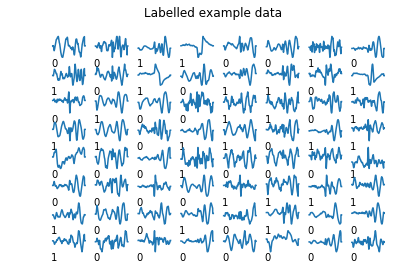

In [10]:
visualiseData(ecgData, classData, 8, False)
#plt.savefig("./outData/figures/messy_mcg_example300buf.pdf")

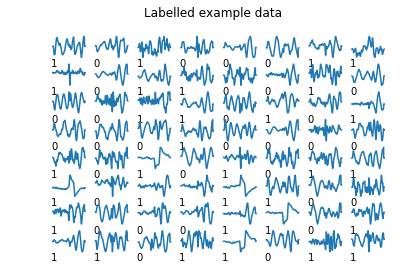

In [11]:
visualiseData(unseenData, unseenClass, 8, False)

# Neural Network

In [12]:
healthEval = []
illEval = []
spec = []
sens = []
unseenSpec = []
unseenSens = []
unseenAvg = []
roc = []

In [13]:
if k != 1:
    for i in np.arange(0,k,1):
        sess = tf.InteractiveSession()
        tf.reset_default_graph()
        tflearn.initializations.normal()

        # Input layer:
        net = tflearn.layers.core.input_data(shape=[None, 2000, 1])

        # First layer:
        net = tflearn.layers.conv.conv_1d(net, 16, 5, activation="leaky_relu")
        net = tflearn.layers.conv.max_pool_1d(net, 2)

        # Second layer:
        net = tflearn.layers.conv.conv_1d(net, 32, 5, activation="leaky_relu")
        net = tflearn.layers.conv.max_pool_1d(net, 2)
        
        # Third layer (added)
        net = tflearn.layers.conv.conv_1d(net, 64, 5, activation="leaky_relu")
        net = tflearn.layers.conv.max_pool_1d(net, 2)

        # Fully connected layer 1:
        net = tflearn.layers.core.fully_connected(net, 1024, regularizer="L2", weight_decay=0.001, activation="leaky_relu")

        # Dropout layer:
        net = tflearn.layers.core.dropout(net, keep_prob=0.5)

        # Output layer:
        net = tflearn.layers.core.fully_connected(net, 2, activation="softmax")

        net = tflearn.layers.estimator.regression(net, optimizer='adam', loss='categorical_crossentropy',\
                                 learning_rate=0.0001)

        model = tflearn.DNN(net, tensorboard_verbose=3)
        dummyData = np.reshape(np.concatenate(kfoldData[:i] + kfoldData[i+1:], axis=0), [-1, 2000, 1])
        dummyLabels = np.reshape(np.concatenate(kfoldLabelsOH[:i] + kfoldLabelsOH[i+1:], axis=0), [-1, 2])
        model.fit(dummyData, dummyLabels, n_epoch=5, show_metric=True)

        illTest = []
        healthTest = []
        for index, item in enumerate(kfoldLabels[i]):
            if item == 1:
                illTest.append(kfoldData[i][index])
            if item == 0:
                healthTest.append(kfoldData[i][index])

        healthLabel = np.tile([1,0], (len(healthTest), 1))
        illLabel = np.tile([0,1], (len(illTest), 1))

        sens.append(model.evaluate(np.array(healthTest), healthLabel))
        spec.append(model.evaluate(np.array(illTest), illLabel))
        
        fpr, tpr, th = roc_curve(kfoldLabels[i], predicted[:,1])
        roc.append((fpr,tpr))
    
        unseenAvg.append(model.evaluate(unseenData, unseenClassOH))
        unseenSpec.append(model.evaluate(np.array(iUnseen), unseenIL))
        unseenSens.append(model.evaluate(np.array(hUnseen), unseenHL))

if k == 1:
    sess = tf.InteractiveSession()
    tf.reset_default_graph()
    tflearn.initializations.normal()

    # Input layer:
    net0 = tflearn.layers.core.input_data(shape=[None, 2000, 1])

    # First layer:
    net1 = tflearn.layers.conv.conv_1d(net0, 32, 10, activation="leaky_relu")
    net2 = tflearn.layers.conv.max_pool_1d(net1, 2)

    # Second layer:
    net3 = tflearn.layers.conv.conv_1d(net2, 64, 5, activation="leaky_relu")
    net4 = tflearn.layers.conv.max_pool_1d(net3, 2)

    # Fully connected layer 1:
    net5 = tflearn.layers.core.fully_connected(net4, 1024, regularizer="L2", weight_decay=0.001, activation="leaky_relu")

    # Dropout layer:
    net6 = tflearn.layers.core.dropout(net5, keep_prob=0.5)

    # Output layer:
    net7 = tflearn.layers.core.fully_connected(net6, 2, activation="softmax")

    net8 = tflearn.layers.estimator.regression(net7, optimizer='adam', loss='categorical_crossentropy',\
                             learning_rate=0.0001)

    model = tflearn.DNN(net0, tensorboard_verbose=3)
    model.fit(ecgData, classDataOH, n_epoch=5, validation_set=0.1, show_metric=True)

Training Step: 379  | total loss: 0.52604 | time: 188.960s
| Adam | epoch: 005 | loss: 0.52604 - acc: 0.7304 -- iter: 4800/4860
Training Step: 380  | total loss: 0.52083 | time: 193.359s
| Adam | epoch: 005 | loss: 0.52083 - acc: 0.7386 | val_loss: 0.54332 - val_acc: 0.7222 -- iter: 4860/4860
--


In [14]:
if k != 1:
    print("Specificity:", spec, "\nAvg:", np.mean(spec), "\nSensitivity:", sens, "\nAvg:", np.mean(sens),\
         "\nUnseen Spec:", unseenSpec, "\nUnseen Sens:", unseenSens, "\nUnseen Avg:", unseenAvg)

else:
    print(model.evaluate(unseenData, unseenClassOH),"\n",\
    model.evaluate(np.array(iUnseen), unseenIL),"\n",\
    model.evaluate(np.array(hUnseen), unseenHL))

[0.66666666348775228] 
 [0.66000000079472865] 
 [0.67333333492279057]


In [1]:
if k != 1:
    for i in np.arange(k):
        plt.plot(roc[i][0], roc[i][1])
        
if k == 1:
    fpr, tpr, th = roc_curve(kfoldLabels[i], predicted[:,1])
    plt.plot(fpr, tpr)

NameError: name 'k' is not defined

In [23]:
netTst = tf.reshape(tf.tile(tf.reshape(net1, [-1]), [15]), [-1, 2000, 15, 30])

## What do the filters look like?

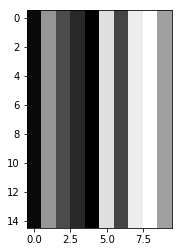

In [76]:
w1 = net1.W
weights1 = model.get_weights(w1)
expandedWeights1 = np.reshape(np.tile(np.reshape(weights1, [10,32]), [15]), [10,15,1,32])
plt.imshow(np.transpose(expandedWeights1[:,:,0,2]), cmap='gray', interpolation='nearest')

(10, 1, 1, 32)


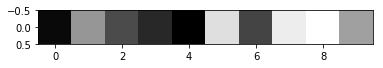

In [77]:
plt.imshow(weights[:,:,0,2].T, cmap='gray', interpolation='nearest')
print(data.shape)

(32,)


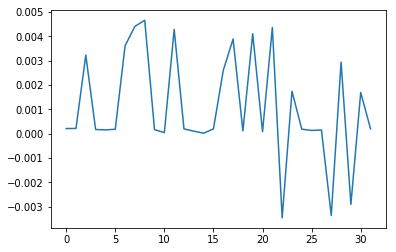

In [75]:
b1 = net1.b
biases1 = model.get_weights(var2)
b2 = net3

[-0.04113662  0.02178097  0.05524268  0.06389304  0.02020742  0.04246902
  0.02952616  0.04233889  0.03648196  0.04936374 -0.02118521  0.00523494
 -0.00143944  0.07094838  0.07398777 -0.01114998  0.04902502 -0.03010315
  0.01704452 -0.0111169   0.05262038 -0.04315055  0.00259386  0.00739525
  0.00888613]


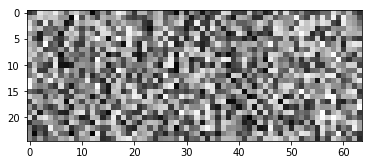

In [35]:
var2 = net3.W
data1 = model.get_weights(var2)
print(data1[:,0,0,0])
plt.imshow(data1[:,0,0], cmap='gray', interpolation='nearest')